In [1]:
Epoch=30
Batch_size=64
Lr=0.01

In [2]:
#导入所需的库与函数
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
import PIL
import torchvision.transforms
from torchvision import datasets, transforms
import pandas as pd
import cv2    #读取图片
import torch
import os     #生成图片的路径
import time
import numpy as np
import shutil
import heapq
import matplotlib.pyplot as plt

In [3]:
def progress(percent, width=50):
    '''
    进度打印功能
    :param percent: 进度
    :param width: 进度条长度
    '''
    if percent >= 100:
        percent = 100

    show_str = ('[%%-%ds]' % width) % (int(width * percent / 100) * "#")  # 字符串拼接的嵌套使用
    print('\r%s %d%%' % (show_str, percent), end='')

In [4]:
title=[]
poem=[]

In [5]:
with open("/mnt/poem/data.txt.txt", "r") as f:
    data = f.readlines()
    count=0
    for line in data:
        line = line.strip('\n')
        if(count%2==0):
            title.append(line)
        else:
            poem.append(line)
        count=count+1
        
print(title)
print(poem)

['楚江怀古', '过故人庄', '留别王维', '清明日宴梅道士房', '秋登兰山寄张五', '宿桐庐江寄广陵旧游', '宿业师山房待丁大不至', '岁暮归南山', '夏日南亭怀辛大', '列女操', '春泛若耶溪', '谷口书斋寄杨补阙', '送僧归日本', '云阳馆与韩绅宿别', '贼平后送人北归', '题大庾岭北驿', '塞上曲', '同从弟南斋玩月忆山阴崔少府', '酬张少府', '归嵩山作', '过香积寺', '汉江临泛', '青溪', '送梓州李使君', '辋川闲居赠裴秀才迪', '终南别业', '']
['露气寒光集，微阳下楚丘。猿啼洞庭树，人在木兰舟。广泽生明月，苍山夹乱流。云中君不见，竟夕自悲秋。', '故人具鸡黍，邀我至田家。绿树村边合，青山郭外斜。开轩面场圃，把酒话桑麻。待到重阳日，还来就菊花。', '寂寂竟何待，朝朝空自归。欲寻芳草去，惜与故人违。当路谁相假，知音世所稀。只应守寂寞，还掩故园扉。', '林卧愁春尽，开轩览物华。忽逢青鸟使，邀入赤松家。金灶初开火，仙桃正发花。童颜若可驻，何惜醉流霞。', '北山白云里，隐者自怡悦。相望试登高，心随雁飞灭。愁因薄暮起，兴是清秋发。时见归村人，沙行渡头歇。天边树若荠，江畔洲如月。何当载酒来，共醉重阳节。', '山暝听猿愁，沧江急夜流。风鸣两岸叶，月照一孤舟。建德非吾土，维扬忆旧游。还将两行泪，遥寄海西头。', '夕阳度西岭，群壑倏已暝。松月生夜凉，风泉满清听。樵人归欲尽，烟鸟栖初定。之子期宿来，孤琴候萝径。', '北阙休上书，南山归敝庐。不才明主弃，多病故人疏。白发催年老，青阳逼岁除。永怀愁不寐，松月夜窗虚。', '山光忽西落，池月渐东上。散发乘夕凉，开轩卧闲敞。荷风送香气，竹露滴清响。欲取鸣琴弹，恨无知音赏。感此怀故人，中宵劳梦想。', '梧桐相待老，鸳鸯会双死。贞妇贵殉夫，舍生亦如此。波澜誓不起，妾心古井水。', '幽意无断绝，此去随所偶。晚风吹行舟，花路入溪口。际夜转西壑，隔山望南斗。潭烟飞溶溶，林月低向后。生事且弥漫，愿为持竿叟。', '泉壑带茅茨，云霞生薜帷。竹怜新雨后，山爱夕阳时。闲鹭栖常早，秋花落更迟。家僮扫萝径，昨与故人期。', '上国随缘住，来途若梦行。浮天沧海远，去世法舟轻。水月通禅寂，鱼龙听梵声。惟怜一灯影，万里眼中明。', '故人江海别，几度隔山川。乍见翻疑梦，相悲各问年。

In [6]:
def split(size, source,dist_train,dist_val):
    folders=os.listdir(source)
    for folder in folders:
        if os.path.isdir(source+'/'+folder):
            td=dist_train+'/'+folder
            vd=dist_val+'/'+folder
            os.mkdir(td)
            os.mkdir(vd)
            files=os.listdir(source+'/'+folder)
            localsize=len(files)
            count=0;
            for afile in files:
                count=count+1
                if count/localsize>0.7:
                    shutil.move((source+'/'+folder+'/'+afile),vd)
                else:
                    shutil.move((source+'/'+folder+'/'+afile),td)

#split(size=0.7,source='PICS',dist_train='train',dist_val='val')



In [7]:
def clean(path):
    folders=os.listdir(path)
    for folder in folders:
        files=os.listdir(path+'/'+folder)
        for afile in files:
            if afile.split('.')[-1]=="jpg":
                pass
            else: 
                if afile.split('.')[-1]=='png':
                    pass
                else:
                    os.remove(path+'/'+folder+'/'+afile)

#clean('val')
#clean('train')

In [8]:
# 对data进行预处理 data augmentation
# Normalization Crop Flip ...
# 详情见 https://pytorch.org/docs/stable/torchvision/transforms.html
########## 自行配置 ###########
train_transform = transforms.Compose([
    transforms.ToPILImage(),#转换成PIL格式，不必设置mode参数
    #transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)
    #transforms.CenterCrop(),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomHorizontalFlip(), # 隨機將圖片水平翻轉
    transforms.RandomRotation(15), # 隨機旋轉圖片
    transforms.ToTensor(), # 將圖片轉成 Tensor，並把數值 normalize 到 [0,1] (data normalization)
])
# testing 時不需做 data augmentation
test_transform = transforms.Compose([
    transforms.ToPILImage(),                                    
    transforms.ToTensor(),
])

In [5]:
dictionary = {}
folderlist = os.listdir('/train')
count = 0
for folder in folderlist:
    dictionary[folder] = count
    count = count + 1
    
print(dictionary)

{'田': 0, '酒': 1, '光': 2, '人': 3, '帝': 4, '草': 5, '木': 6, '衣': 7, '山': 8, '路': 9, '海': 10, '兵': 11, '水': 12, '室': 13, '眼': 14, '帆': 15, '浪': 16, '柳': 17, '船': 18, '石': 19, '霞': 20, '雨': 21, '星': 22, '手': 23, '霜': 24, '雪': 25, '花': 26, '.DS_Store': 27, '琴': 28, '紫': 29, '僧': 30}


In [10]:
class mySet(Dataset):
    def __init__(self,path,trans=None):
        '''
        param:
            direct:父文件路径
            trans：图片处理
            构造一个词典，是题目:图片的形式
        '''
        self.path = path
        self.trans = trans
        self.label=[]
        self.img=[]
        count=0
        folderlist = os.listdir(path)
        for folder in folderlist:
            piclist = os.listdir(path+'/'+folder)
            for pic in piclist:
                image = PIL.Image.open(path + '/' + folder + '/' + pic)
                image = image.resize((128,64),PIL.Image.ANTIALIAS)
                if image.size[0]!=3:
                    image = image.convert("RGB")
                self.label.append(dictionary[folder])
                tran=transforms.ToTensor()
                image=tran(image)
                self.img.append(image)
            count = count + 1 
            progress(count/len(folderlist)*100)
        print("Init of Dataset has been done!")
    
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self,idx):
        img = self.img[idx]
        label = self.label[idx]
        if self.trans is not None:
            img = self.trans(img)
        return img, label
        

In [11]:
train_path='/train'
val_path='/val'

In [12]:
train_set=mySet(train_path,train_transform)
val_set=mySet(val_path,test_transform)
train_loader = DataLoader(train_set, batch_size=Batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=Batch_size, shuffle=False)

[######################                            ] 45%

/root/miniconda3/envs/myconda/lib/python3.8/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[##################################################] 100%Init of Dataset has been done!
[##################################################] 100%Init of Dataset has been done!


In [14]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        # 经过处理后的x要与x的维度相同(尺寸和深度)
        # 如果不相同，需要添加卷积+BN来变换为同一维度
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


# 用于ResNet50,101和152的残差块，用的是1x1+3x3+1x1的卷积
class Bottleneck(nn.Module):
    # 前面1x1和3x3卷积的filter个数相等，最后1x1卷积是其expansion倍
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=91):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*8, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, test = False):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = torch.squeeze(out) 
        out = out.view(out.size(0), -1)
        if test:
            out = out.view(-1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = ResNet34()
#model.to(device)

def training():
    loss = nn.CrossEntropyLoss() # 因為是 classification task，所以 loss 使用 CrossEntropyLoss
    optimizer = torch.optim.Adam(model.parameters(), lr=Lr) # optimizer 使用 Adam

    for epoch in range(Epoch):
        epoch_start_time = time.time()
        train_acc = 0.0
        train_loss = 0.0
        val_acc = 0.0
        val_loss = 0.0

        model.train() # 確保 model 是在 train model (開啟 Dropout 等...)
        for data, label in train_loader:
            optimizer.zero_grad() # 用 optimizer 將 model 參數的 gradient 歸零
            train_pred = model(data.to(device)) # 利用 model 得到預測的機率分佈 這邊實際上就是去呼叫 model 的 forward 函數
            batch_loss = loss(train_pred, label.long().to(device)) # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
            batch_loss.backward() # 利用 back propagation 算出每個參數的 gradient
            optimizer.step() # 以 optimizer 用 gradient 更新參數值

            train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == label.numpy())
            train_loss += batch_loss.item()

        model.eval()
        with torch.no_grad():
            for data, label in val_loader:
                val_pred = model(data.to(device))
                batch_loss = loss(val_pred, label.to(device))

                val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(), axis=1) == label.numpy())
                val_loss += batch_loss.item()

            #將結果 print 出來
            print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
                (epoch + 1, Epoch, time.time()-epoch_start_time, \
                 train_acc/train_set.__len__(), train_loss/train_set.__len__(), val_acc/val_set.__len__(), val_loss/val_set.__len__()))


In [16]:
#training()

[001/030] 6.56 sec(s) Train Acc: 0.070698 Loss: 0.122162 | Val Acc: 0.049356 loss: 501.247379
[002/030] 6.61 sec(s) Train Acc: 0.083721 Loss: 0.070880 | Val Acc: 0.096567 loss: 0.779317
[003/030] 6.61 sec(s) Train Acc: 0.118140 Loss: 0.060558 | Val Acc: 0.148069 loss: 0.053274
[004/030] 6.54 sec(s) Train Acc: 0.157209 Loss: 0.051421 | Val Acc: 0.214592 loss: 0.053405
[005/030] 6.61 sec(s) Train Acc: 0.174884 Loss: 0.047789 | Val Acc: 0.178112 loss: 0.046627
[006/030] 6.62 sec(s) Train Acc: 0.239070 Loss: 0.042015 | Val Acc: 0.221030 loss: 0.043992
[007/030] 6.73 sec(s) Train Acc: 0.219535 Loss: 0.042001 | Val Acc: 0.229614 loss: 0.044379
[008/030] 6.73 sec(s) Train Acc: 0.226047 Loss: 0.040808 | Val Acc: 0.229614 loss: 0.043122
[009/030] 6.73 sec(s) Train Acc: 0.266047 Loss: 0.039623 | Val Acc: 0.278970 loss: 0.042991
[010/030] 6.68 sec(s) Train Acc: 0.271628 Loss: 0.037800 | Val Acc: 0.283262 loss: 0.041139
[011/030] 6.68 sec(s) Train Acc: 0.258605 Loss: 0.037797 | Val Acc: 0.317597 l

In [22]:
model=torch.load('/mnt/ResNet34.pth')

In [23]:
#torch.save(model,"/mnt/ResNet34.pth")

In [24]:
def show(path, top = 5):
    images = os.listdir(path)
    for img in images:
        image = PIL.Image.open(path + '/' + img)
        image = image.resize((128,64),PIL.Image.ANTIALIAS)
        plt.imshow(image)
        plt.show()
        if image.size[0]!=3:
            image = image.convert("RGB")
        ten = transforms.ToTensor()
        image = ten(image)
        image.permute(0,2,1)
        image = image.unsqueeze(0)
        out = model(image.to(device),test=True).to('cpu').detach().numpy()
        idx = heapq.nlargest(top, range(len(out)), out.__getitem__)
        pred = []
        for index in idx:
            ans = list(dictionary.keys())[list(dictionary.values()).index(index)]
            pred.append(ans)
        print(pred)

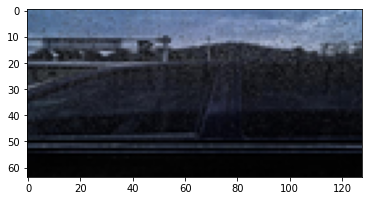

['山', '雨', '星', '海', '光']


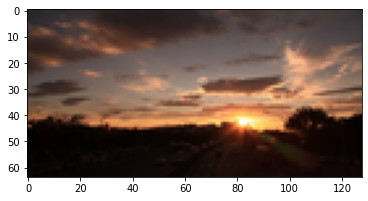

['霞', '僧', '石', '光', '船']


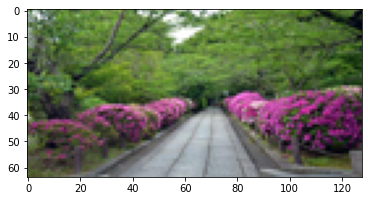

['水', '雨', '船', '僧', '柳']


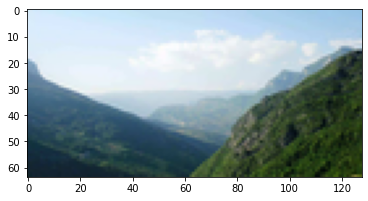

['山', '路', '雨', '水', '柳']


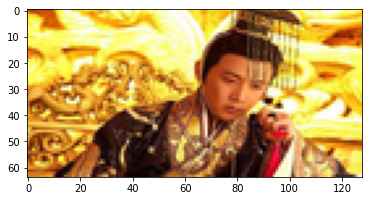

['帝', '光', '船', '僧', '酒']


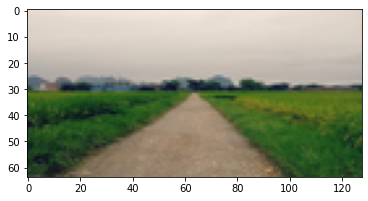

['路', '草', '室', '石', '田']


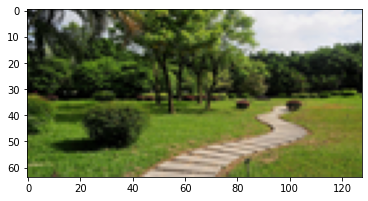

['柳', '草', '花', '木', '田']


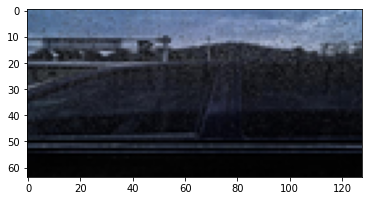

['山', '雨', '星', '海', '光']


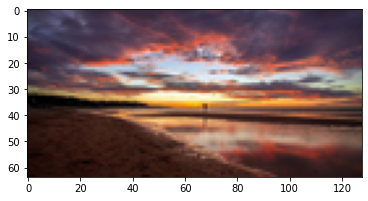

['霞', '室', '石', '僧', '雨']


In [26]:
#show('test')

In [27]:
PoemModel = PoemModel.load_state_dict(torch.load('/mnt/model85.pth'))
print(PoemModel)

OrderedDict([('embeddings.weight', tensor([[ 0.1818,  0.1296, -0.6126,  ...,  0.7803, -0.7295, -1.0975],
        [-0.4459, -0.1953,  0.0744,  ..., -0.2473,  0.4126,  0.8059],
        [-0.4388, -1.1792,  0.4988,  ...,  0.0347, -1.0252,  1.6502],
        ...,
        [-1.1006, -1.0039,  0.6035,  ...,  1.4160,  0.2617,  1.4846],
        [-0.3387, -0.7051,  0.5866,  ..., -0.1553, -1.7739,  1.2777],
        [ 1.0201, -0.1901, -0.9130,  ..., -1.2347, -0.7671, -0.2249]],
       device='cuda:0')), ('lstm.weight_ih_l0', tensor([[-0.0413, -0.0810, -0.0473,  ...,  0.0595,  0.1074, -0.0424],
        [ 0.0161,  0.0525, -0.1357,  ..., -0.0271,  0.0805, -0.0667],
        [-0.1332,  0.0300,  0.1171,  ..., -0.1780, -0.1175,  0.2176],
        ...,
        [ 0.1180, -0.2048,  0.0440,  ..., -0.0449, -0.2330,  0.0074],
        [ 0.1085, -0.0671, -0.1217,  ...,  0.0247,  0.0420, -0.0304],
        [ 0.3590, -0.0157,  0.0110,  ..., -0.1007,  0.0813,  0.2152]],
       device='cuda:0')), ('lstm.weight_hh_l0', t

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=